# Quick comparison: R and Python GRASS interfaces

Veronica Andreo  
2024-04-01

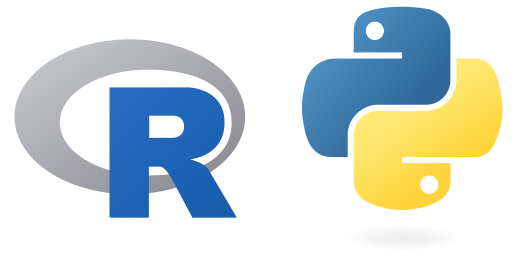

In this short tutorial we will highlight the similarities of R and
Python GRASS interfaces in order to streamline the use of GRASS within R
and Python communities. As you may know, there’s an R package called
[rgrass](https://github.com/OSGeo/rgrass/) that provides basic
functionality to read and write data from and into GRASS database as
well as to execute GRASS tools in either existing or temporary GRASS
projects. The [GRASS Python
API](https://grass.osgeo.org/grass-stable/manuals/libpython/index.html),
on the other hand, is composed of various packages that provide classes
and functions for low and high level tasks, including those that can be
executed with rgrass.

There are some parallelisms between the **rgrass** and
**grass.script**/**grass.jupyter** packages, i.e., R and Python
interfaces to GRASS. Let’s review them and go through some examples.

| Task | rgrass function | GRASS Python API function |
|-----------------------------|----------------|----------------------------|
| Load library | library(rgrass) | import grass.script as gs<br>import grass.jupyter as gj |
| Start GRASS and set all needed <br>environmental variables | initGRASS() | gs.setup.init() for scripts,<br>gj.init() for notebooks |
| Execute GRASS commands | execGRASS() | gs.run_command(),<br>gs.read_command(),<br>gs.parse_command() |
| Read raster and vector data <br>from GRASS | read_RAST(),<br>read_VECT() | gs.array.array(),<br>n/a |
| Write raster and vector data<br>into GRASS | write_RAST(),<br>write_VECT() | gs.array.write(),<br>n/a |
| Get raster and vector info | n/a,<br>vInfo() | gs.raster_info(),<br>gs.vector_info() |
| Close GRASS session | unlink\_.gislock() | gs.setup.finish(),<br>gj.finish() |

R and Python GRASS interfaces compared

## Comparison examples

Let’s see how usage examples would look like.

1.  **Load the library**: We need to load the libraries that allow us to
    interface with GRASS functionality and (optionally) data. For the
    Python case, we first need to add the GRASS python package path to
    our system’s path.

## R

``` r
library(rgrass)
```

## Python

``` python
import sys
import subprocess

sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

import grass.script as gs
import grass.jupyter as gj
```

1.  **Start a GRASS session**: Once we loaded or imported the packages,
    we start a GRASS session. We need to pass the path to a temporary or
    existing GRASS project. In the case of R, `initGRASS` will
    automatically look for GRASS binaries, alternatively we can specify
    the path to the binaries ourselves. In the case of Python, it is
    worth noting that while grass.script and grass.jupyter init
    functions take the same arguments, `gj.init` also sets other
    environmental variables to streamline work within Jupyter Notebooks,
    e.g., overwrite is set to true so cells can be executed multiple
    times.

## R

``` r
session <- initGRASS(gisBase = "/usr/lib/grass84", # where grass binaries live, `grass --config path`
                     gisDbase = "/home/user/grassdata", # path to grass database or folder where your project lives
                     location = "nc_basic_spm_grass7", # existing project name
                     mapset = "PERMANENT" # mapset name
                     )
```

## Python

``` python
# With grass.script for scripts
session = gs.setup.init(path="/home/user/grassdata",
              location="nc_basic_spm_grass7",
              mapset="PERMANENT")
# Optionally, the path to a mapset
session = gs.setup.init("/home/user/grassdata/nc_basic_spm_grass7/PERMANENT")

# With grass.jupyter for notebooks
session = gj.init(path="/home/user/grassdata",
                  location="nc_basic_spm_grass7",
                  mapset="PERMANENT")
# Optionally, the path to a mapset
session = gj.init("~/grassdata/nc_basic_spm_grass7/PERMANENT")
```

1.  **Execute GRASS commands**: Both interfaces work pretty similarly,
    the first argument is always the GRASS tool name and then we pass
    the parameters and flags. While in R we basically use `execGRASS()`
    for all GRASS commands, in the Python API, we have different
    wrappers to execute GRASS commands depending on the nature of their
    output.

## R

``` r
# Map output
execGRASS("r.slope.aspect",
          elevation = "elevation",
          slope = "slope",
          aspect = "aspect")

# Text output
execGRASS("g.region",
          raster = "elevation",
          flags = "p")
```

## Python

``` python
# Map output
gs.run_command("r.slope.aspect",
               elevation="elevation",
               slope="slope",
               aspect="aspect")
# Text output
print(gs.read_command("g.region",
                      raster="elevation",
                      flags="p"))
# Text output - dictionary
region = gs.parse_command("g.region",
                          raster="elevation",
                          flags="g")
region
```

1.  **Read raster and vector data into other R or Python formats**:
    *rgrass* functions `read_RAST()` and `read_VECT()` convert GRASS
    raster and vector maps into terra’s SpatRaster and SpatVector
    objects within R. In the case of Python, GRASS raster maps that can
    be converted into numpy arrays through `gs.array.array()`. Vector
    attribute data can be converted into Pandas data frames in various
    ways.

## R

``` r
# Raster
elevr <- read_RAST("elevation")

# Vector
schoolsr <- read_VECT("schools")
```

## Python

``` python
# Raster into numpy array
elev = gs.array.array("elevation")

# Vector attributes
import pandas as pd
schools = gs.parse_command("v.db.select", map="schools", format="json")
pd.DataFrame(schools["records"])

# Vector geometry and attributes to GeoJSON
gs.run_command("v.out.ogr", input="schools", output="schools.geojson", format="GeoJSON")
```

1.  **Write R or Python objects into GRASS raster and vector maps**: R
    terra’s SpatRaster and SpatVector objects can be written (back) into
    GRASS format with `write_RAST()` and `write_VECT()` functions.
    Within the Python environment, numpy arrays can also be written
    (back) into GRASS raster maps with the `write()` method.

## R

``` r
# Raster
write_RAST(elevr, "elevation_r")

# Vector
write_VECT(schoolsr, "schools_r")
```

## Python

``` python
# Raster
elev.write(mapname="elev_np", overwrite=True)

# GeoJSON into GRASS vector
gs.run_command("v.in.ogr", input="schools.geojson", output="schools2")
```

1.  **Close GRASS session**: In general, just closing R or Rstudio, as
    well as shutting down Jupyter notebook, will clean up and close the
    GRASS session properly. Sometimes, however, especially if the user
    changed mapset within the workflow, it is better to clean up
    explicitly before closing.

## R

``` r
unlink_.gislock()
```

## Python

``` python
session.finish()
```

## Final remarks

The examples and comparisons presented here are intended to facilitate
the combination of tools and languages as well as the exchange of data
and format conversions. We hope that’s useful as a starting point for
the implementation of different use cases and workflows that suit the
needs of users. See R and Python tutorials for more examples:

-   [GRASS and Python tutorial for
    beginners](../get_started/fast_track_grass_and_python.qmd)
-   [GRASS and R tutorial for
    beginners](../get_started/fast_track_grass_and_R.qmd)

## References

-   [GRASS Python API
    docs](https://grass.osgeo.org/grass-stable/manuals/libpython/index.html)
-   [rgrass docs](https://osgeo.github.io/rgrass/)

------------------------------------------------------------------------

The development of this tutorial was funded by the US [National Science
Foundation (NSF)](https://www.nsf.gov/), award
[2303651](https://www.nsf.gov/awardsearch/showAward?AWD_ID=2303651).